In [22]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.optim as optim
import copy
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, Dataset, DataLoader
import time


In [2]:
# Unzipping dataset
#import zipfile
#with zipfile.ZipFile("./DataSet/archive-4.zip", 'r') as zip_ref:
#    zip_ref.extractall("./DataSet/Bird")

In [3]:
# Translating the output
from translate import Translator
def translator(sentence, language_code):
    translator = Translator(to_lang=str(language_code))
    return translator.translate(sentence)

In [4]:
import matplotlib.pyplot as plt
import random
def plot_digit(data):
    plt.imshow(data)
    plt.show()

class BirdDataset(Dataset):

    def __init__(self, imgs, METADATA, test = False) -> None:

        self.img_tensor = imgs
        self.METADATA = METADATA
        self.test = test
    def __getitem__(self, index):
        if not self.test:
            caption_id = self.METADATA['train_val_img_ids'][index]
            caption_nr = random.randint(0,9)
            caption = self.METADATA['img_id_to_encoded_caps'][caption_id][caption_nr]
            caption = np.pad(np.array(caption), (0, 86 - len(caption)), 'constant')
            caption_tensor = torch.tensor(caption, dtype=torch.long)  # Shape: (10, 87)
            return self.img_tensor[index], caption_tensor
        
        else: 
            caption_id = self.METADATA['test_img_ids'][index]
            caption_nr = random.randint(0,9)
            caption = self.METADATA['img_id_to_encoded_caps'][caption_id][caption_nr]
            caption = np.pad(np.array(caption), (0, 86 - len(caption)), 'constant')
            caption_tensor = torch.tensor(caption, dtype=torch.long)  # Shape: (10, 87)
            return self.img_tensor[index], caption_tensor
            
    def __len__(self):
        return self.img_tensor.shape[0]
    



In [5]:
# Data Loading
TRAIN_VAL = torch.load("./DataSet/Bird/archive-4/imgs_train_val_256x256.pth")
METADATA = torch.load("./DataSet/Bird/archive-4/metadata.pth", weights_only = False)
TEST_DATA = torch.load("./DataSet/Bird/archive-4/imgs_test_256x256.pth")

DATASET = BirdDataset(TRAIN_VAL, METADATA)
train, val = torch.utils.data.random_split(DATASET, [0.7, 0.3])

TESTSET = BirdDataset(TEST_DATA, METADATA)

train_loader = DataLoader(train, batch_size = 10, num_workers = 8)
val_loader = DataLoader(val, batch_size = 10, num_workers = 8)
test_loader = DataLoader(TESTSET, batch_size = 10, num_workers = 8)

print(METADATA.keys())

dict_keys(['img_ids', 'img_id_to_class_id', 'class_id_to_class_name', 'class_name_to_class_id', 'train_val_class_ids', 'test_class_ids', 'train_val_img_ids', 'test_img_ids', 'word_freq', 'word_id_to_word', 'word_to_word_id', 'img_id_to_encoded_caps', 'num_imgs', 'num_classes', 'num_captions_per_image', 'num_words'])


In [19]:
class CNN(nn.Module):
    def __init__(self, context_dim):
        super().__init__()
        self.backbone = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove last layers
        self.conv_project = nn.Conv2d(512, context_dim, kernel_size=1)       # Project to context_dim

    def forward(self, x):
        features = self.backbone(x) 
        features = self.conv_project(features) 
        features = features.flatten(2).transpose(1, 2)  # [batch, H*W, context_dim]
        return features


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        num_layers = 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Recurrent layer
        # TODO:
        self.lstm = nn.LSTM(input_size=self.input_size,
                         hidden_size=self.hidden_size,
                         num_layers=num_layers,
                         bidirectional=False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=self.hidden_size,
                            out_features=self.input_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        # TODO:
        x, (h, c) = self.lstm(x)
        
        #print(self.lstm.hidden_size)
        # Flatten output for feed-forward layer
        #x = x.view(-1, self.lstm.hidden_size)
        # Output layer
        # TODO:
        x = self.l_out(x)
        #print(x.shape)
        return x

In [8]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)

        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """
        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)
            
        Q = Q.unsqueeze(1)
        
        # Compute attention scores (dot product of Q and K)
        scoremats = torch.matmul(Q, K.transpose(-2, -1))  # [batch, seq_len, context_len]
        
        # Apply softmax to get attention weights
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # [batch, seq_len, context_len]
        
        # Compute context vectors by applying attention weights to the values
        ctx_vecs = torch.matmul(attnmats, V)  # [batch, seq_len, hidden_dim]
        ctx_vecs = ctx_vecs.squeeze(1)
        return ctx_vecs

In [9]:
class LeGigaChad(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, encoded_img_size):
        super().__init__()
        self.cnn = CNN(encoded_img_size)
        self.lstm = nn.LSTM(embed_dim, hidden_dim)
        self.cross_attention = CrossAttention(embed_dim, hidden_dim, encoded_img_size)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, embedded_captions):
        # images: [batch, C, H, W]
        # embedded_captions: [batch, seq_len, embed_dim]
        batch_size, seq_len = images.size(0), embedded_captions.size(1)

        # CNN feature extraction
        image_features = self.cnn(images)  # [batch, num_regions, context_dim]
        # Initialize hidden state
        h0 = torch.zeros(1, batch_size, self.lstm.hidden_size, device=images.device)
        c0 = torch.zeros(1, batch_size, self.lstm.hidden_size, device=images.device)
        # Compute static attention once
        attended = self.cross_attention(h0.squeeze(0), image_features)  # [batch, embed_dim]
        attended = attended.unsqueeze(1).repeat(1, seq_len, 1)
        # Combine embeddings and attention
        lstm_input = embedded_captions + attended  # [batch, seq_len, embed_dim]
        lstm_input = lstm_input.permute(1, 0, 2)
        # Feed through LSTM
        outputs, _ = self.lstm(lstm_input, (h0, c0))  # [batch, seq_len, hidden_dim]
        outputs = self.fc_out(outputs)  # [batch, seq_len, vocab_size]

        return outputs

            
        

In [10]:
# Training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    tensorboard_logging_path = "/tf/logs/Lab3" + str(time.time())
    writer = SummaryWriter(log_dir=tensorboard_logging_path)
    counter_train = 0
    counter_val = 0
    best_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        for batch_nr, (images, captions) in enumerate(train_loader):
            counter_train += 1
            start = torch.full((captions.size(0), 1), 1747).to(device)  # Start token
            end = torch.full((captions.size(0), 1), 1748).to(device)    # End token
            images = images.to(device).float()
            captions = captions.to(device)
            captions = torch.cat((start, captions, end), dim=-1).long()
            captions = F.one_hot(captions, 1750)
    
            predictions = model(images, captions)  # [batch_size, seq_len, vocab_size]
            predictions = predictions.permute(1,0,2)
            
            loss = 0
            # Compute the loss for each token (excluding the start token)
            for t in range(1, captions.size(1)):  # Excluding the start token (index 0)
                predicted_tokens = predictions[:, t - 1, :]  # Predictions for the current token
                true_tokens = captions[:, t]  # True tokens (shifted by one)
                true_tokens = torch.argmax(true_tokens, dim=-1)
                # Compute loss for each token in the sequence (cross entropy loss)
                loss += criterion(predicted_tokens, true_tokens.long())
    
            loss /= captions.size(1) - 1  # Average loss over the sequence length (excluding the start token)
    
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the model weights
            optimizer.zero_grad()  # Reset gradients
    
            # Print training progress
            print(f"epoch: {epoch}, batch: {batch_nr}/{len(train_loader)}, loss: {loss.item():.4f}", end="\r")
    
            # Log loss to TensorBoard
            writer.add_scalar('Loss Batch / Train', loss.item(), counter_train)
    
            # Clean up to free memory
            del loss, predictions, images, captions, start, end
        print()
            

        model.eval()
        with torch.no_grad():
            for batch_nr, (images, captions) in enumerate(val_loader):
                counter_val += 1
                print(counter_val, end = "\r")
                start = torch.full((captions.size(0), 1), 1747).to(device)  # Start token
                end = torch.full((captions.size(0), 1), 1748).to(device)    # End token
                images = images.to(device).float()
                captions = captions.to(device)
                captions = torch.cat((start, captions, end), dim=-1).long()
                captions = F.one_hot(captions, 1750)
        
                predictions = model(images, captions)  # [batch_size, seq_len, vocab_size]
                predictions = predictions.permute(1,0,2)
                
                loss = 0
                # Compute the loss for each token (excluding the start token)
                for t in range(1, captions.size(1)):  # Excluding the start token (index 0)
                    predicted_tokens = predictions[:, t - 1, :]  # Predictions for the current token
                    true_tokens = captions[:, t]  # True tokens (shifted by one)
                    true_tokens = torch.argmax(true_tokens, dim=-1)
                    # Compute loss for each token in the sequence (cross entropy loss)
                    loss += criterion(predicted_tokens, true_tokens.long())
                    
                loss /= captions.size(1) - 1  # Average loss over the sequence length (excluding the start token)
    
        
        
                # Log loss to TensorBoard
                writer.add_scalar('Loss Batch / Validation', loss.item(), counter_val)
        
                if loss < best_loss:
                    best_loss = loss
                    torch.save(model, "dumheterevigheterstorheter")

                # Clean up to free memory
                del loss, predictions, images, captions, start, end
                
    return model
                

In [20]:
# Data Loading
TRAIN_VAL = torch.load("./DataSet/Bird/archive-4/imgs_train_val_256x256.pth")
METADATA = torch.load("./DataSet/Bird/archive-4/metadata.pth", weights_only = False)
TEST_DATA = torch.load("./DataSet/Bird/archive-4/imgs_test_256x256.pth")

DATASET = BirdDataset(TRAIN_VAL, METADATA)
train, val = torch.utils.data.random_split(DATASET, [0.7, 0.3])

TESTSET = BirdDataset(TEST_DATA, METADATA)

train_loader = DataLoader(train, batch_size = 10, num_workers = 8)
val_loader = DataLoader(val, batch_size = 10, num_workers = 8)
test_loader = DataLoader(TESTSET, batch_size = 10, num_workers = 8)




MAIN

In [23]:
vocab_size = 1750
encoded_img_size = 256
embed_dim = vocab_size
hidden_dim = vocab_size
num_epochs = 100
device = torch.device('cuda')
model = LeGigaChad(vocab_size, hidden_dim, embed_dim, encoded_img_size)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s] 


epoch: 0, batch: 619/620, loss: 0.8095
epoch: 1, batch: 619/620, loss: 1.3108
epoch: 2, batch: 619/620, loss: 0.8031
epoch: 3, batch: 619/620, loss: 0.8974
epoch: 4, batch: 619/620, loss: 0.5564
epoch: 5, batch: 619/620, loss: 0.7566
epoch: 6, batch: 619/620, loss: 0.5963
epoch: 7, batch: 619/620, loss: 0.5635
epoch: 8, batch: 619/620, loss: 0.4763
epoch: 9, batch: 619/620, loss: 0.8635
epoch: 10, batch: 619/620, loss: 0.6185
epoch: 11, batch: 619/620, loss: 0.5469
epoch: 12, batch: 619/620, loss: 0.5570
epoch: 13, batch: 619/620, loss: 0.4152
epoch: 14, batch: 619/620, loss: 0.4536
epoch: 15, batch: 619/620, loss: 0.5773
epoch: 16, batch: 619/620, loss: 0.4113
epoch: 17, batch: 619/620, loss: 0.3863
epoch: 18, batch: 619/620, loss: 0.4356
epoch: 19, batch: 619/620, loss: 0.6602
epoch: 20, batch: 619/620, loss: 0.3979
epoch: 21, batch: 619/620, loss: 0.3181
epoch: 22, batch: 619/620, loss: 0.3539
epoch: 23, batch: 619/620, loss: 0.7180
epoch: 24, batch: 619/620, loss: 0.5881
epoch: 25,

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
def generate_caption(model, image, metadata, max_len=50, start_token=1747, end_token=1748, device='cpu'):
    model.eval()
    device = torch.device(device)
    model = model.to(device)

    # Prepare input
    image = image.unsqueeze(0).to(device).float()  # [1, C, H, W]
    caption_tokens = [start_token]

    # Initial one-hot caption input: [1, 1, vocab_size]
    caption_input = F.one_hot(torch.tensor(caption_tokens, device=device), num_classes=1750).unsqueeze(0).float()

    with torch.no_grad():
        for _ in range(max_len):
            next_token = None
            output = model(image, caption_input)  # [1, seq_len, vocab_size]
            next_token_logits = output[:, -1, :]   # [1, vocab_size]
            next_token = torch.argmax(next_token_logits, dim=-1)  # [1]
            next_token_id = next_token[-1].item()
            caption_tokens.append(next_token_id)
            next_token = next_token.squeeze()  # OR use next_token = next_token[0] if batch size is 1
            if next_token.dim() != 0:
                next_token = next_token[-1]  # ensure it's a scalar

            next_token_oh = F.one_hot(next_token, num_classes=1750).view(1, 1, -1).float()
            
            #caption_tokens.append(next_token_id)

            if next_token_id == end_token:
                break

            # Append next token to caption input
            #next_token_oh = F.one_hot(next_token, num_classes=1750).unsqueeze(1).float()  # [1, 1, 1750]
            caption_input = torch.cat((caption_input, next_token_oh), dim=1)  # grow seq_len: [1, t+1, 1750]
    # Decode token IDs (excluding <start> and <end>)
    decoded_ids = caption_tokens[1:]  # exclude <start>
   
    # Remove <end> token if it's the last one
    if len(decoded_ids) > 0 and decoded_ids[-1] == end_token:
        decoded_ids = decoded_ids[:-1]
    while decoded_ids[-1] == 0:
        decoded_ids = decoded_ids[:-1]

    # Convert to list of words
    words = [metadata["word_id_to_word"][idx] for idx in decoded_ids]
    caption_str = ' '.join(words)
    caption_str = eng_to_swe(caption_str)
    return caption_str, decoded_ids


In [111]:
import torch
import torch.nn.functional as F
import heapq

def generate_caption_beam_search(model, image, metadata, max_len=50, start_token=1747, end_token=1748, beam_width=3):
    model.eval()
    
    device = torch.device("cuda")
    model = model.to(device)

    image = image.unsqueeze(0).to(device).float()  # [1, C, H, W]

    # Beam: (score, [token_ids], caption_input)
    start_input = F.one_hot(torch.tensor([start_token], device=device), num_classes=1750).unsqueeze(0).float()  # [1, 1, vocab_size]
    beam = [(0.0, [start_token], start_input)]

    completed_sequences = []

    with torch.no_grad():
        for _ in range(max_len):
            new_beam = []
            for score, tokens, caption_input in beam:
                output = model(image, caption_input)  # [1, seq_len, vocab_size]
                output = output.permute(1,0,2)
                next_token_logits = output[:, -1, :]  # [1, vocab_size]
                log_probs = F.log_softmax(next_token_logits, dim=-1).squeeze(0)  # [vocab_size]

                topk_log_probs, topk_indices = torch.topk(log_probs.squeeze(0), beam_width)

                for log_prob, token_id in zip(topk_log_probs, topk_indices):
                    token_id = int(token_id)  # Ensures scalar
                    new_score = score + log_prob.item()
                    new_tokens = tokens + [token_id]
                
                    if token_id == end_token:
                        completed_sequences.append((new_score, new_tokens))
                        continue
                
                    next_token_oh = F.one_hot(torch.tensor([token_id], device=device), num_classes=1750).view(1, 1, -1).float()
                    new_caption_input = torch.cat((caption_input, next_token_oh), dim=1)
                    new_beam.append((new_score, new_tokens, new_caption_input))

            if not new_beam:
                break  # All sequences have ended

            # Keep top beam_width sequences
            beam = heapq.nlargest(beam_width, new_beam, key=lambda x: x[0])

    # Choose best completed sequence
    if completed_sequences:
        best_sequence = max(completed_sequences, key=lambda x: x[0])[1]
    else:
        # Fallback to best incomplete sequence
        best_sequence = beam[0][1]

    decoded_ids = best_sequence[1:]  # Exclude <start>
    if decoded_ids and decoded_ids[-1] == end_token:
        decoded_ids = decoded_ids[:-1]
    while decoded_ids and decoded_ids[-1] == 0:
        decoded_ids = decoded_ids[:-1]

    words = [metadata["word_id_to_word"][idx] for idx in decoded_ids]
    words[0] = words[0].capitalize()
    caption_str = ' '.join(words)
    caption_str = translator(caption_str, 'sv')
    caption_str = caption_str.strip()
    caption_str = caption_str + "."
    return caption_str, decoded_ids


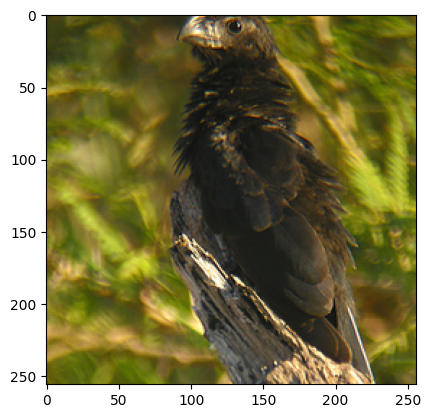

Denna fågel är brun med vit och har en mycket kort näbb ..


In [114]:
model = torch.load("dumheterevigheterstorheter", weights_only = False)
image = TEST_DATA[17]  # Assuming batch size = 1
plot_digit(image.permute(1,2,0))
#caption_str, _ = generate_caption(model, image, METADATA)
caption_str, _ = generate_caption_beam_search(model, image, METADATA, beam_width = 3)
print(f"{caption_str}")